# Setting up Chroma
For the numerical exercises we will use the Chroma software suite https://github.com/JeffersonLab/chroma. Chroma can be compiled with different libraries to run calculations both on CPUs and GPUs. We will use precompiled CPU only version that runs on google colab.
Run the next 2 cells to download and set the environment for the exercises.


In [113]:
%rm -r /home/software /home/tests /home/chroma_gcolab/ /home/run*
%mkdir /home/software
%cd /home/software
!gdown https://drive.google.com/uc?id=16woEAYY0VPJqufF2574Q1AM2NFh13qH1
!unzip chroma.zip
!rm chroma.zip
!chmod u+rwx /home/software/chroma/install/chroma/bin/*
%cd /home
!git clone https://github.com/henrymonge/chroma_gcolab.git
!mv chroma_gcolab/tests .
%cd /home/chroma_gcolab
!git pull
! pip install mpi4py
!pip install lsqfit
!pip install h5py
import importlib
from io_params import *
import numpy as np
import gvar as gv
import h5py as h5
import lsqfit

shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
/home/software
Downloading...
From (original): https://drive.google.com/uc?id=16woEAYY0VPJqufF2574Q1AM2NFh13qH1
From (redirected): https://drive.google.com/uc?id=16woEAYY0VPJqufF2574Q1AM2NFh13qH1&confirm=t&uuid=1a2c3e35-fcdc-41ab-bc76-21b5652d19bf
To: /home/software/chroma.zip
100% 175M/175M [00:01<00:00, 102MB/s] 
Archive:  chroma.zip
   creating: chroma/
  inflating: __MACOSX/._chroma       
   creating: chroma/install/
  inflating: __MACOSX/chroma/._install  
  inflating: chroma/.DS_Store        
  inflating: __MACOSX/chroma/._.DS_Store  
  inflating: chroma/hmc.prec_wilson.ini.xml  
  inflating: __MACOSX/chroma/._hmc.prec_wilson.ini.xml  
   creating: chroma/install/qdpxx/
  inflating: __MACOSX/chroma/install/._qdpxx  
   creating: chroma/install/chroma/
  inflating: __MACOSX/chroma/install/._chroma  
   creating: chroma/install/qmp/
  inflating: __MACOSX/chroma/insta

In [114]:
%cd /home/software/chroma
%env TOPDIR_HIP=/home/software/chroma
%env INSTALLROOT=${TOPDIR_HIP}/install
%env LD_LIBRARY_PATH=/home/software/chroma/install/chroma/lib:/home/software/chroma/install/qdpxx/lib:/home/software/chroma/install/qmp/lib

#Load python modules

%cd /home/chroma_gcolab/modules
import importlib
import xml_input
import defs
importlib.reload(defs)


/home/software/chroma
env: TOPDIR_HIP=/home/software/chroma
env: INSTALLROOT=${TOPDIR_HIP}/install
env: LD_LIBRARY_PATH=/home/software/chroma/install/chroma/lib:/home/software/chroma/install/qdpxx/lib:/home/software/chroma/install/qmp/lib
/home/chroma_gcolab/modules


<module 'defs' from '/home/chroma_gcolab/modules/defs.py'>

#Lattice QCD Numerical Calculations

Lattice QCD calculations are commonly performed in three stages:

1. Gauge field generation
2. Quark propagator computation/Constructing observables from quark propagators
4. Extracting physical quantities


#Stage 2: Computing quark propagators

A quark propagator can be obtained by inverting the Dirac operator $D$. To build $D$, we will need a gauge field configuration and a discretization scheme. For the gauge field, we use the ones generated using Monte Carlo importance sampling. The action used in the gauge field generate defines the gauge and sea quark properties. The discretization scheme used to represent the Dirac operator on the Lattice will determine the properties of the valence quarks and the observables we compute with these quarks. Moreover, simulating the physical process on a finite volume and a finite grid introduces errors, and therefore the choice of the discretization is relevant for determining systematics errors.

To obtain $D^{-1}$. Instead, one can solve the following equation:

\begin{align}
D P = S
\end{align}

where the propagator $P=D^{-1}$.

Solving the above system of linear equations is a well-known problem and  existing techniques can be used. For Lattice QCD, iterative methods are used. An iterative method we will require performing the matrix operation $D P$ multiple times. In principle, you implement this operation using an array for $D$ and $P$, nevertheless as $D$ is sparse it is more efficient to implement the operation of $D$ on $P$; This saves both memory and computing time.

Once the iterative method has been implemented, what we need to the computer is the gauge field and source.

#Add info on solvers


## Multiple solves

For a propagator, the system we solve is at every space-time point is

\begin{align}
D_x P_x = S_x
\end{align}

The application of $D_x$ is independent of $x$ and thus we can distribute this calculate and compute the $V=L^3 T$ sites in parallel. Now, the solution $P_x$ depends on the source $S_x$ we pass, but the $D_x$ does not. Moreover, for every solve we need to load the parameters necessary to apply $D$. If you do not have enough work to do at a given $x$, after every application the workers will need to wait until the data is passed. For the Lattice QCD, this is the case. A technique used to increase performance is the multi-right hand side MRS. In the MRS, we pass multiple sources and solve at once. In this way, only the for first source we need to wait for the $D$ data. This technique requires more memory but reduces the communications.


In [103]:
params={}
params['VOL']='4 4 4 32'
params['ACTION']='WILSON'
params['MASS']='-0.5' #'-0.05,-0.1'
params['INVERTER']='CG_INVERTER'
params['RES']='1.0e-8'
params['ITER']='1000'
outdir='/home/run_0'
%mkdir $outdir
ini,out,log,stdout=defs.writeInputFileProp(params,outdir) #update input file
inic=ini+'.txt'
! mpiexec --allow-run-as-root --oversubscribe -np 1 /home/software/chroma/install/chroma/bin/chroma -geom 1 1 1 1 -i $ini -o $out -l $log > $stdout 2>&1
!echo "Input file is {ini}"
!cp $ini $inic
!grep -r "CHROMA: total time =" $stdout


mkdir: cannot create directory ‘/home/run_0’: File exists
Input file is /home/run_0/prop.ini.xml
CHROMA: total time = 4.420029 secs


# Mass dependence
Run multiple calculations changing the quark mass and compare timings.

In [105]:
#Run 1
params={}
params['VOL']='4 4 4 32'
params['ACTION']='WILSON'
params['MASS']='-0.05'#'-0.05,-0.1'
params['INVERTER']='CG_INVERTER'
params['RES']='1.0e-8'
params['ITER']='1000'
outdir='/home/run_1'
%mkdir $outdir
ini,out,log,stdout=defs.writeInputFileProp(params,outdir) #update input file
inic=ini+'.txt'
! mpiexec --allow-run-as-root --oversubscribe -np 1 /home/software/chroma/install/chroma/bin/chroma -geom 1 1 1 1 -i $ini -o $out -l $log > $stdout 2>&1
!echo "Input file is {ini}"
!cp $ini $inic
!grep -r "CHROMA: total time =" $stdout
!grep -r " iterations." $stdout

mkdir: cannot create directory ‘/home/run_1’: File exists
Input file is /home/run_1/prop.ini.xml
CHROMA: total time = 10.769886 secs
CG_SOLVER: 105 iterations. Rsd = 2.11787374433626e-08 Relative Rsd = 3.60778500629568e-08
CG_SOLVER: 105 iterations. Rsd = 2.14391146287904e-08 Relative Rsd = 3.65220578678012e-08
CG_SOLVER: 109 iterations. Rsd = 1.32056499641507e-08 Relative Rsd = 2.24957441709932e-08
CG_SOLVER: 109 iterations. Rsd = 1.31656013104341e-08 Relative Rsd = 2.24279249049943e-08
CG_SOLVER: 105 iterations. Rsd = 2.1018109402858e-08 Relative Rsd = 3.58104190175246e-08
CG_SOLVER: 106 iterations. Rsd = 2.07968963179198e-08 Relative Rsd = 3.54379173564793e-08
CG_SOLVER: 105 iterations. Rsd = 2.27466743550685e-08 Relative Rsd = 3.87555285919018e-08
CG_SOLVER: 109 iterations. Rsd = 1.3927252384752e-08 Relative Rsd = 2.37320421022822e-08
CG_SOLVER: 105 iterations. Rsd = 2.2588945330058e-08 Relative Rsd = 3.84907917244316e-08
CG_SOLVER: 104 iterations. Rsd = 2.2514864752809e-08 Relativ

In [ ]:
#Run 2
params={}
params['VOL']='4 4 4 32'
params['ACTION']='WILSON'
params['MASS']='-0.5'#'-0.05,-0.1'
params['INVERTER']='CG_INVERTER'
params['RES']='1.0e-8'
params['ITER']='1000'
outdir='/home/run_1'
%mkdir $outdir
ini,out,log,stdout=defs.writeInputFileProp(params,outdir) #update input file
inic=ini+'.txt'
! mpiexec --allow-run-as-root --oversubscribe -np 1 /home/software/chroma/install/chroma/bin/chroma -geom 1 1 1 1 -i $ini -o $out -l $log > $stdout 2>&1
!echo "Input file is {ini}"
!cp $ini $inic
!grep -r "CHROMA: total time =" $stdout
!grep -r " iterations." $stdout

#Even-Odd preconditioning

The goal of preconditioning is to solve indirectly the problem using a different operator. In Lattice QCD, the Dirac operator can be decomposed in even and odd sites using Schur's decomposition as follows:


\begin{align}
D&=\left[\begin{array}{cc}
D_{e e} & - D_{e o} \\
D_{o e} & D_{o o}
\end{array}\right]\\
&=\left[\begin{array}{cc}
1 &  0 \\
D_{o e} D_{ee}^{-1} & 1
\end{array}\right] \left[\begin{array}{cc}
D_{ee} &  0 \\
0 & D_{oo}-D_{o e} D^{-1} D_{eo}
\end{array}\right]\left[\begin{array}{cc}
1 &   D_{ee}^{-1} D_{eo} \\
0& 1
\end{array}\right] \\
&= L \tilde{D} U
\end{align}


\begin{align}
D\chi=L\tilde{D}U \chi =\psi \rightarrow  \tilde{D}(U \chi) =L^{-1}\psi
\end{align}

The solution of the latter equation will be $\chi´ = U\chi$, from which you get the solution as $\chi = U^{-1}\chi$.

The form of $D$ will depend on the discretization chosen, therefore for different types of fermions and solvers, the implementation is different.


In [106]:
#Run 3 UNPREC_WILSON
params={}
params['VOL']='4 4 4 32'
params['ACTION']='UNPRECONDITIONED_WILSON'
params['MASS']='-0.5'
params['INVERTER']='CG_INVERTER'
params['RES']='1.0e-8'
params['ITER']='1000'
outdir='/home/run_1'
%mkdir $outdir
ini,out,log,stdout=defs.writeInputFileProp(params,outdir) #update input file
inic=ini+'.txt'
! mpiexec --allow-run-as-root --oversubscribe -np 1 /home/software/chroma/install/chroma/bin/chroma -geom 1 1 1 1 -i $ini -o $out -l $log > $stdout 2>&1
!echo "Input file is {ini}"
!cp $ini $inic
!grep -r "CHROMA: total time =" $stdout
!grep -r " iterations." $stdout


mkdir: cannot create directory ‘/home/run_1’: File exists
Input file is /home/run_1/prop.ini.xml
CHROMA: total time = 27.093141 secs
CG_SOLVER: 265 iterations. Rsd = 6.42598662582617e-08 Relative Rsd = 6.42598662582617e-08
CG_SOLVER: 266 iterations. Rsd = 6.32549510313872e-08 Relative Rsd = 6.32549510313872e-08
CG_SOLVER: 266 iterations. Rsd = 6.63284467501006e-08 Relative Rsd = 6.63284467501006e-08
CG_SOLVER: 265 iterations. Rsd = 6.79246416738039e-08 Relative Rsd = 6.79246416738039e-08
CG_SOLVER: 277 iterations. Rsd = 4.50183047886464e-08 Relative Rsd = 4.50183047886464e-08
CG_SOLVER: 277 iterations. Rsd = 4.79997398751332e-08 Relative Rsd = 4.79997398751332e-08
CG_SOLVER: 277 iterations. Rsd = 4.67185662669531e-08 Relative Rsd = 4.67185662669531e-08
CG_SOLVER: 277 iterations. Rsd = 4.83775783090389e-08 Relative Rsd = 4.83775783090389e-08
CG_SOLVER: 277 iterations. Rsd = 4.78007973752266e-08 Relative Rsd = 4.78007973752265e-08
CG_SOLVER: 277 iterations. Rsd = 4.46728685950262e-08 Rel

# Hadron spectrum

Computing the hadron spectrum is straighforward, at any given space-time point, what we need to do is to contract a set of matrices and then we perform a fourier transform.

The number of terms to contractions depends of the observable and their symmetries. For computing the correlation function for a single particle the only thing we want to do is to do the contraction in parallel at every space-time point. When we compute more particles, there may be opportunities for reusing some data.

Here is an example to show how to put together quarks to make pions given the correlation function:


\begin{align*}
 \left\langle \pi^+ \vert \pi^{+\dagger} \right\rangle = -\left\langle  \bar{d} \gamma^5 u  \vert \bar{u} \gamma^5 d \right\rangle
\end{align*}

Therefore the pion correlator becomes, for source y and sink x:
\begin{align*}

each fermion field $d,u$ have a space-time, a spin and a color index. The wick contraction of the the field and the anti-field is the propagator for the quark:

\begin{align*}
 P^d = \left\langle d \bar{d} \right\rangle
\end{align*}

Now you can perform the wick contractions and replace with $P$'s.

\begin{align*}
\left\langle \pi^+ \vert \pi^{+\dagger} \right\rangle
  =&\left\langle  d(y)_{\sigma b} \bar{d(x)}_{\alpha a} \right\rangle \gamma^5_{\alpha \beta} \left\langle u(x)_{\beta a} \bar{u(y)}_{\delta b} \right\rangle \gamma^5_{\delta \sigma} &\\
  =&P^d(y,x)_{\sigma b \alpha a} \gamma^5_{\alpha \beta} P^u(x,y)_{\beta a \delta b} \gamma^5_{\delta \sigma}  &\\
  =& \gamma^5_{\alpha \beta} \gamma^5_{\alpha \beta}  P^d(y,x)_{\sigma b \alpha a} \gamma^5_{\alpha \beta} P^u(x,y)_{\beta a \delta b} \gamma^5_{\delta \sigma}  &\\
  =& \gamma^5_{\sigma \sigma'} (P^d(x,y))^\dagger_{\sigma' b \beta a} P^u(x,y)_{\beta a \delta b} \gamma^5_{\delta \sigma}  
\end{align*}

The last expression tells us how to contract the propagators we have computed to obtain a pion correlation function. In chroma the code looks like this:


```
 LatticePropagator anti_quark_prop =  Gamma(G5) * quark_prop_2 * Gamma(G5); //gamma_value=15 -> G5

corr_fn = trace(adj(anti_quark_prop) * (Gamma(gamma_value) *
                    quark_prop_1 * Gamma(gamma_value)));
```


#Running Chroma

To maximize resource usage,we can split the problem.
In chroma, you can use -geom 1 1 1 1



In [116]:
#params.update({'VOL':' 4 4 4 8','CFG':'WEAK_FIELD'})
params={}
outdir='/home/run_hadspec'
%mkdir $outdir
ini,out,log,stdout=defs.writeInputFileHadspec(params,outdir) #update input file
!echo "Input file is {ini}"

Input file is /home/run_hadspec/hadspec.ini.xml


In [118]:
#!/home/software/chroma/install/chroma/bin/chroma -geom 1 1 1 1 -i $ini -o $out -l $log > $stdout 2>&1
! mpiexec --allow-run-as-root --oversubscribe -np 1 /home/software/chroma/install/chroma/bin/chroma -geom 1 1 1 1 -i $ini -o $out -l $log > $stdout 2>&1

!echo "Corr is stored here {out}"
'''
Look for lines
 1130 -> <Shell_Point_Wilson_Mesons>
 1777 ->  <Shell_Point_Wilson_Mesons>
'''

Corr is stored here /home/run_hadspec/hadspec.out


'\nLook for lines\n 1130 -> <Shell_Point_Wilson_Mesons>\n 1777 ->  <Shell_Point_Wilson_Mesons>\n'


# Extracting the mass spectrum

To extract observables from the calculations, the analytical expression for the correlation function can be used to fit the data.

For baryons, such as the proton and neutron we have:

\begin{align}
C(t)=\sum_n A_ne^{-E_nt}
\end{align}

and for mesons, such as the pion:
\begin{align}
C(t)=\sum_n A_n(e^{-E_nt} - e^{-E_n(T-t)})
\end{align}

The next cells have a fitting routine to extract the effective mass from previously computed correlation functions.

In [94]:
%cd /home/chroma_gcolab/corr_fitter/
plt.ion()

f=h5.File('../a09m260_a_avg_srcs0-7.h5')
particle='piplus'  #kplus,lambda_z,omega_m,piplus,proton
isMeson=particle in ['kminus','kplus','piplus']

path='gf1p0_w3p5_n45_M51p1_L58_a1p5/spec/ml0p00702_ms0p0481'
#Retrieve data
if isMeson:
    corr=f[path+f'/{particle}/psq_0/corr'][()].real
    lims=[0,96,0.1,0.2] #pion
else:
    corr_spin_dn=f[path+f'/{particle}/psq_0/spin_dn'][()].real
    corr_spin_up=f[path+f'/{particle}/psq_0/spin_up'][()].real
    corr=(corr_spin_dn+corr_spin_up)  #spin average
    lims=[0,30,0.4,0.9] #proton
corr=corr[:,:,1,0]

#time extent
T=corr.shape[1]

/home/chroma_gcolab/corr_fitter


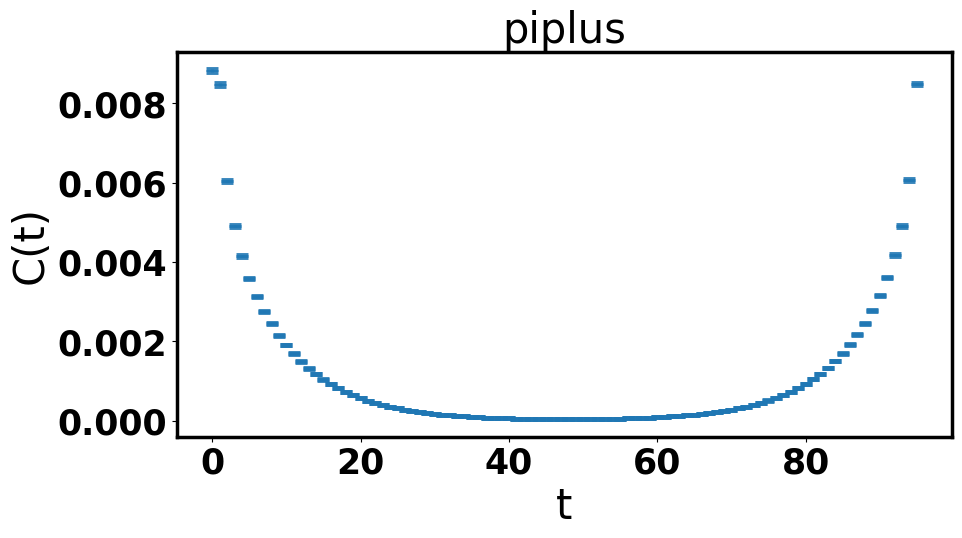

In [79]:
#Pack the mean and std into a gvar
j=1
x=np.arange(T)
y=gv.dataset.avg_data(corr)
y_pj = np.roll(y,-j)
y_mj = np.roll(y,j)

#Plot correlator
fig = plt.figure(1,figsize=(10,5))
ax=plt.subplot()
ax.errorbar(np.arange(T),gv.mean(y), yerr=gv.sdev(y),ms=ms,mew=mew,
                mfc='None',capsize=capsize,linestyle='None',alpha=0.9)
ax.set_xlabel('t')
ax.set_ylabel('C(t)')
#ax.axis(lims)
plt.title(particle)
plt.show(block=False)

/tmp/ipython-input-95-1751681170.py:4: RuntimeWarning: invalid value encountered in sqrt
  meff =  1. / j * np.arccosh((y_pj+y_mj) / 2 / y )


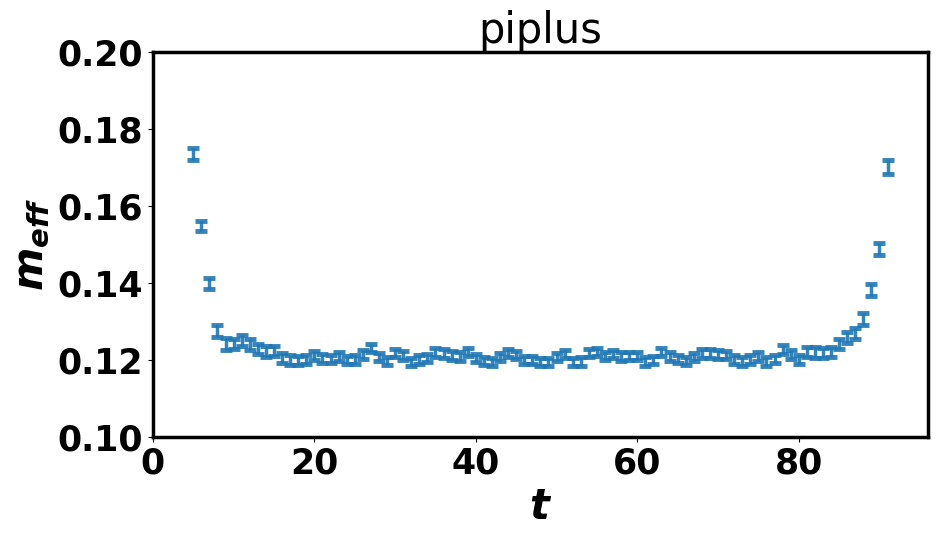

In [95]:
#plot effective mass
#Compute the meff
if isMeson:
    meff =  1. / j * np.arccosh((y_pj+y_mj) / 2 / y )
else:
    meff =  1. / j * np.log( y / y_pj )

#Plot meff
fig = plt.figure(2,figsize=(10,5))
ax=plt.subplot()
ax.errorbar(np.arange(T),gv.mean(meff), yerr=gv.sdev(meff),ms=ms,mew=mew,
                mfc='None',capsize=capsize,linestyle='None',alpha=0.9)
ax.set_xlabel('$t$')
ax.set_ylabel('$m_{eff}$')
ax.axis(lims)
plt.title(particle)
plt.show()

In [100]:
#define fit function
def fcn(x, p,isMeson=False):       #function used to fit x, y data
    nt=x.shape[0]
    temp=np.zeros(shape=(nt))
    result=gv.gvar(temp,temp)
    a0=p['A0']
    E=[gv.fabs(e) for e in p['E']]
    E0=E[0]
    E[0]=0.0
    result=sum(ai * np.exp(-(E0+Ei) * x) for ai, Ei in zip(a0, E))
    if isMeson:
      result=sum(ai * np.exp(-(E0+Ei) * x + ai * np.exp(-(E0+Ei) * -(T-x))) for ai, Ei in zip(a0, E))
    return result

In [101]:
#Fit the effective Mass

prior={}

tmin,tmax=10,20

#1 state
print('*'*40+'1 state fit'+'*'*40)
prior['A0']=[gv.gvar(0.50,40)]
prior['E']=[gv.gvar(0.53,40)]
fit = lsqfit.nonlinear_fit(data=(x[tmin:tmax], y[tmin:tmax]), fcn=fcn, prior=prior)
print(fit)		  # print the fit results

#2 states
print('*'*40+'1 state fit'+'*'*40)
prior['A0']=[gv.gvar(0.50,40),gv.gvar(0.50,40)]
prior['E']=[gv.gvar(0.53,40),gv.gvar(0.53,40)]
fit = lsqfit.nonlinear_fit(data=(x[tmin:tmax], y[tmin:tmax]), fcn=fcn, prior=prior)
print(fit)		  # print the fit results


****************************************1 state fit****************************************
Least Squares Fit:
  chi2/dof [dof] = 2.2 [10]    Q = 0.018    logGBF = 102.81

Parameters:
           A0 0   0.006404 (33)      [ 0.5 (40.0) ]  
            E 0   -0.12103 (20)      [ 0.5 (40.0) ]  

Settings:
  svdcut/n = 1e-12/0    tol = (1e-08*,1e-10,1e-10)    (itns/time = 38/0.0s)
  fitter = scipy_least_squares    method = trf

****************************************1 state fit****************************************
Least Squares Fit:
  chi2/dof [dof] = 0.4 [10]    Q = 0.95    logGBF = 95.135

Parameters:
           A0 0   0.006297 (73)      [ 0.5 (40.0) ]  
              1     0.0022 (35)      [ 0.5 (40.0) ]  
            E 0    0.12018 (53)      [ 0.5 (40.0) ]  
              1       0.38 (23)      [ 0.5 (40.0) ]  

Settings:
  svdcut/n = 1e-12/0    tol = (1e-08,1e-10,1e-10*)    (itns/time = 85/0.1s)
  fitter = scipy_least_squares    method = trf



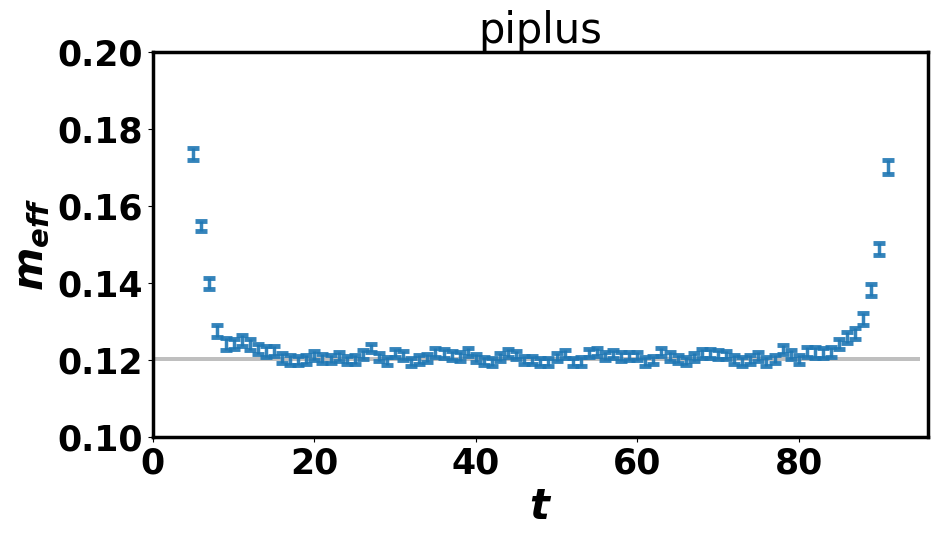

In [102]:
#Plot meff fit
fig = plt.figure(2,figsize=(10,5))
ax=plt.subplot()
ax.errorbar(np.arange(T),gv.mean(meff), yerr=gv.sdev(meff),ms=ms,mew=mew,
                mfc='None',capsize=capsize,linestyle='None',alpha=0.9)
ax.set_xlabel('$t$')
ax.set_ylabel('$m_{eff}$')
ax.axis(lims) #proton

#posterior fit.p['E']
meff_fit=fit.p['E'][0]
ax.fill_between(x,meff_fit.mean-meff_fit.sdev, meff_fit.mean+meff_fit.sdev,facecolor='k',alpha=0.25)
plt.title(particle)
plt.show()

